# Questions

In [33]:
import os

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from scipy.stats import chi2, bernoulli
import seaborn as sns
import matplotlib.pyplot as plt

from src import settings

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (9, 3)

# Question 1
Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.

In the [introduction](introduction:auction_formulation) we described how an optimal auction strategy can be described as :

$$
E(Z) = \sum_{i=1}^{n} \ \underbrace{p_{x_i, s_i}}_{\text{Probability to win the auction}} \ . \ \underbrace{(E(V_i \mid X_i) - s_i)}_{\text{auction payoff}} \qquad (2)
$$

In the following, we model $p_{x_i, s_i}$, the probability to win the auction. We saw in the EDA, the **cumulative probability function** of winning is a **monotone increasing** function of the **bidding price** while it is almost a **monotone decreasing** function of the **features X**. Based on these observation, the **logistic regression** is a **reasonable class of model** for modelling the probability of winning the auction and be used as a baseline. Moreover, it has the **advantage** to **build parameters confidence interval** that can be used to build a **confidence** around the **probability** of winning the auction.

## Build a baseline model based on X and the bidding price

In [2]:
df = pd.read_csv(os.path.join(settings.PROJECT_ROOT, settings.AUCTION_SUMMARY_FILE))

In [3]:
df = df.assign(winning_bid=lambda x: (x.bid >= x.auctions).astype(int))
df.winning_bid.value_counts()

winning_bid
0    457
1     48
Name: count, dtype: int64

In [4]:
df.head()

,x,bid,auctions,wins,winning_bid
0,0.585202,2.719391,7,7,0
1,4.567498,2.688336,2,2,1
2,1.481628,0.200173,4,0,0
3,0.828790,0.187734,4,0,0
4,1.988679,5.792509,7,7,0


In [5]:
df = df.assign(train_test=lambda x: np.random.choice(["train", "test"], size=x.shape[0], p=[0.8, 0.2]))

In [6]:
df.train_test.value_counts()

train_test
train    409
test      96
Name: count, dtype: int64

In [7]:
X_train = df.query("train_test == 'train'").copy()
X_test = df.query("train_test == 'test'").copy()

In [8]:
model = smf.logit("winning_bid ~ x + bid", data=X_train)

In [9]:
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.219055
         Iterations 8


In [10]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            winning_bid   No. Observations:                  409
Model:                          Logit   Df Residuals:                      406
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:                  0.2785
Time:                        23:13:34   Log-Likelihood:                -89.593
converged:                       True   LL-Null:                       -124.18
Covariance Type:            nonrobust   LLR p-value:                 9.561e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7956      0.562     -8.533      0.000      -5.897      -3.694
x              0.1783      0.119      1.501      0.133      -0.054       0.411
bid            0.7962      0.110      7.223      0.000       0.580       1.012
==============================================================================
"""

## Test the model

In [11]:
X_train = X_train.assign(predictions=res.predict(exog=X_train))

In [12]:
X_test = X_test.assign(predictions=res.predict(exog=X_test))

In order to test the quality of predictions, we want to test if the probabilities are well **calibrated**. For doing so, we will use the Hoslem-Lemeshow statistical test. The null hypothesis for the test is that the expected proportions from the model are the same as those observed across all subgroups, i.e., the model is a good fit.

In [13]:
X_test[["predictions", "winning_bid"]]

,predictions,winning_bid
0,0.074040,0
5,0.014315,0
8,0.040532,0
17,0.091092,0
18,0.031625,0
...,...,...
463,0.133916,0
464,0.053803,0
476,0.117116,1
488,0.103114,1


In [14]:
# Adapted from https://jbhender.github.io/Stats506/F18/GP/Group5.html
y_prob = X_test[["predictions", "winning_bid"]].copy()
y_prob["decile"] = pd.qcut(y_prob["predictions"], 10)

obsevents_pos = y_prob.groupby("decile", observed=True)[["winning_bid"]].sum()
obsevents_neg = y_prob.groupby("decile", observed=True)[["winning_bid"]].count() - obsevents_pos
expevents_pos = y_prob.groupby("decile", observed=True)[["predictions"]].sum()
expevents_neg = y_prob.groupby("decile", observed=True)[["predictions"]].count() - expevents_pos

hl = (
    (
        (obsevents_neg.values - expevents_neg.values)**2
        /
        expevents_neg.values
    ).sum()
    +
    (
        (obsevents_pos.values - expevents_pos.values) **2
        /
        expevents_pos.values
    ).sum()
)
print("chi-square: {:.2f}".format(hl))
pvalue = 1 - chi2.cdf(hl, 8)
print("p-value: {:.2f}".format(pvalue))

final = pd.concat([obsevents_pos, obsevents_neg, expevents_pos, expevents_neg], axis =1)
final.columns=['obs_pos','obs_neg','exp_pos', 'exp_neg']
final.style.format(precision=1)

chi-square: 8.57
p-value: 0.38


,obs_pos,obs_neg,exp_pos,exp_neg
decile,,,,
"(0.0091, 0.0156]",0,10,0.1,9.9
"(0.0156, 0.0195]",0,10,0.2,9.8
"(0.0195, 0.0244]",1,8,0.2,8.8
"(0.0244, 0.0271]",1,9,0.3,9.7
"(0.0271, 0.0361]",0,9,0.3,8.7
"(0.0361, 0.0632]",0,10,0.5,9.5
"(0.0632, 0.0937]",0,9,0.7,8.3
"(0.0937, 0.122]",2,8,1.1,8.9
"(0.122, 0.286]",2,7,1.8,7.2


The p-value is 0.45 so we **cannot reject** the model is well calibrated.

* We can also try to visualise how many red and bleu dots there are in each bins :

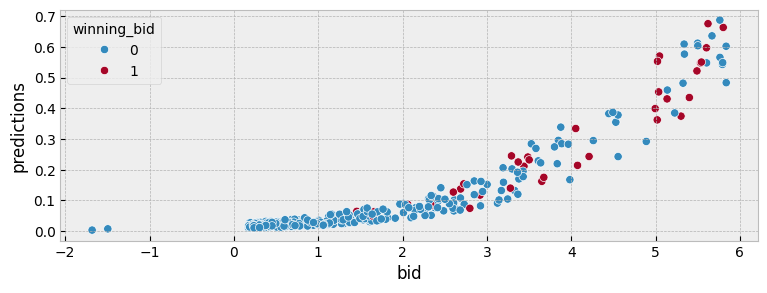

In [15]:
# train set
sns.scatterplot(X_train, x="bid", y="predictions", hue="winning_bid");

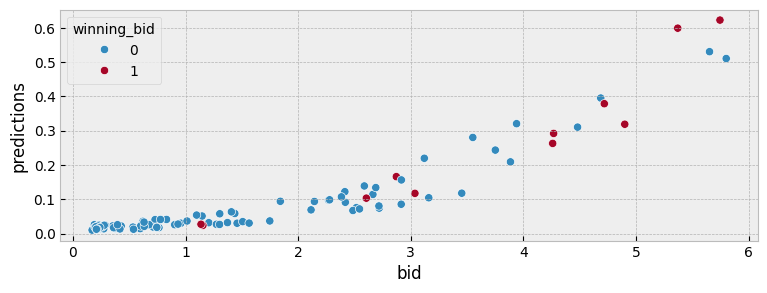

In [16]:
# test set
sns.scatterplot(X_test, x="bid", y="predictions", hue="winning_bid");

## Show confidence interval of predictions

We will use the interval confidence of the parameter to build confidence intervals.

In [17]:
res.conf_int()

,0,1
Intercept,-5.897158,-3.694104
x,-0.054469,0.411007
bid,0.580132,1.012198


In [18]:
lower_coefs, upper_coefs = res.conf_int().values.T

* We will plot an example for x = 2

In [19]:
X_test_uncertainties = pd.DataFrame({"bid": np.arange(0, 7, 0.1), "x": 2})

In [20]:
X_test_uncertainties["cdf"] = res.predict(X_test_uncertainties)
X_test_uncertainties["cdf_lower"] = model.cdf(np.dot(
    X_test_uncertainties.assign(intercept=1)[["intercept", "x", "bid"]].values,
    lower_coefs
))
X_test_uncertainties["cdf_upper"] = model.cdf(np.dot(
    X_test_uncertainties.assign(intercept=1)[["intercept", "x", "bid"]].values,
    upper_coefs
))

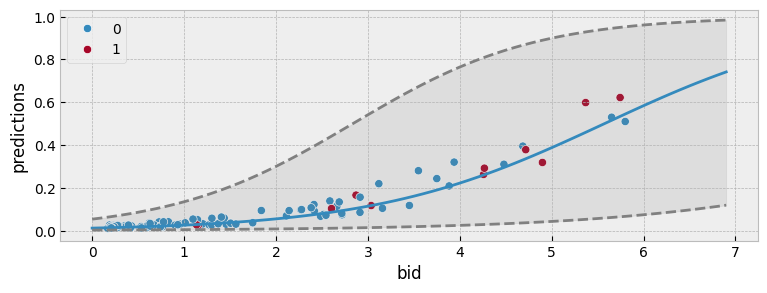

In [21]:
_, ax = plt.subplots()
sns.scatterplot(X_test, x="bid", y="predictions", hue="winning_bid");
sns.lineplot(X_test_uncertainties, x="bid", y="cdf");
sns.lineplot(X_test_uncertainties, x="bid", y="cdf_lower", color="gray", linestyle="--");
sns.lineplot(X_test_uncertainties, x="bid", y="cdf_upper", color="gray", linestyle="--");
ax.fill_between(X_test_uncertainties.bid, X_test_uncertainties.cdf_lower, X_test_uncertainties.cdf_upper,
                color="gray", alpha=0.15);

# Question 2
Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?

## Derive the probability density function for the winning bid for x=3

In [22]:
X_test_cond = pd.concat([
    pd.DataFrame({"bid": np.arange(0, 11, 0.1), "x": x})
    for x in range(1, 9, 2)
], ignore_index=True)
X_test_cond["cdf"] = res.predict(X_test_cond)

In [23]:
X_test_cond["pdf"] = model.pdf(np.dot(
    X_test_cond.assign(intercept=1)[["intercept", "x", "bid"]].values,
    res.params.values
))

* We derive the probability of winning for different values of x, containing x=3.

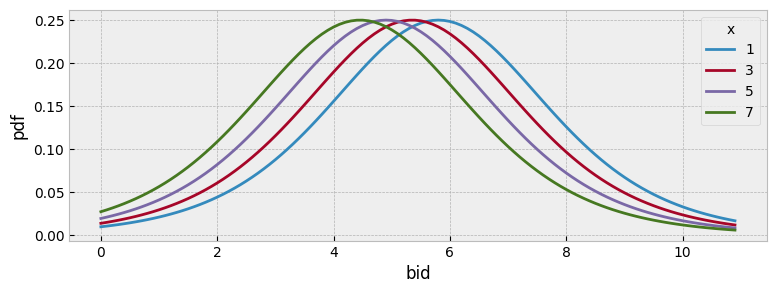

In [24]:
sns.lineplot(X_test_cond.astype({"x": "category"}), x="bid", y="pdf", hue="x");

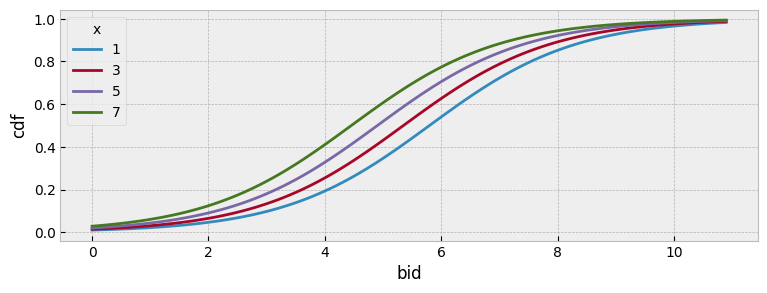

In [25]:
sns.lineplot(X_test_cond.astype({"x": "category"}), x="bid", y="cdf", hue="x");

> the probability of winning the bid increases as x increase. We also analysed in the EDA that the value of the auction was a decreasing function of x. If other biders have the information, they are more willing to pay higher price for low value of x making the **auctions more difficult to win** for **lower x** values.

## What is the probability that the winning bid lies between 1 and 2?

The question can be asked by computing the integral $\int_{x=0}^{x=+\infty} \int_{s=1}^{s=2} p(s, x)dxds$

For simplicity here, we will conduct the **Rieman approximation** of this integral (knowing this shouldn't be done in high dimension).

In [26]:
xv, yv = np.meshgrid(np.arange(1, 2, 0.05), np.arange(0, 20, 0.1))

In [27]:
xv.shape

(200, 20)

In [28]:
X_test_ = pd.DataFrame({"bid": xv.flatten(), "x": yv.flatten()})

In [29]:
res.predict(X_test_).mean()

0.17977878393417887

The probability that the winning bid lies between 1 and 2 is approximately **20%**.

# Question 3
Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?

* The total costs is the sum of all bids won :

In [64]:
df.query("winning_bid == True").bid.sum()

179.73999018527235

However this is **only one realization** of the random variable defined in the [introduction](introduction:auction_formulation) :
$$
\sum_{i=1}^{n} E(W_i \mid X_i, s_i)
$$

If we would do the auction again with the **same bids**, there will be auctions **won prevously** we **don't win** this time and **conversely**.

In order to know **analytically** the probability of observing **costs larger** than in the provided dataset, we should consider all $2^{n}$  possible (win, loss) auction combinations in the dataset, where n is the dataset size. All these $2^{n}$ combinations have a probability of winning of $\prod_{i=1}^{i=n}P(x_i, s_i)$ we can compute based on our model. The final results would be given by:

$$
\sum_{i / \sum_i s_i > 179} \prod_{i=1}^{i=n}P(x_i, s_i)
$$

However this result is **not computationally tractable**.

* Instead, we will make a **simulation** based on our model and approximate this result.

In [34]:
bernouilli_parameters = res.predict(df)

* Instantiate a **bernouilli distribution** object and then make **sample** for **simulating** the **winning bids**.

In [43]:
distribution = bernoulli(bernouilli_parameters)

In [63]:
distribution.rvs().sum()

55

In [ ]:
simulation = df[["bids"]].copy()

In [ ]:
simulations = []

In [48]:
simulations = []
for i in range(10_000):
    simulations.append(
        df[["bid"]].copy().assign(winning_bid=distribution.rvs(), simulation_number=i)
    )
simulations = pd.concat(simulations, ignore_index=True)

In [50]:
simulations.shape

(5050000, 3)

In [68]:
bidding_costs = (
    simulations
    .query("winning_bid == 1")
    .groupby("simulation_number")
    [["bid"]]
    .sum()
)
bidding_costs.head()

,bid
simulation_number,
0,171.208583
1,168.014422
2,164.472296
3,149.685321
4,135.514872


In [66]:
bidding_costs.max()

bid    250.735233
dtype: float64

In [65]:
(bidding_costs > df.query("winning_bid == True").bid.sum()).mean()

bid    0.3804
dtype: float64

There are approximately **38%** chance to see cost greater observing costs larger than in the provided dataset.